# BSSD - Blind Source Separation Denoising

**main function: denoise(** *video, fr, mask, n_ROIs_out=16, n_ROIs_in=16* **)**

Return ROIs masks, means from ROIs masks and time.

Divide cell mask into two major regions (inner and outter region), then divide these regions into smaller regions of interest (ROIs) with similar area following cell shape. The number of ROIs in each major region can be adjusted by *n_ROIs_out* and *n_ROIs_in* arguments. Also, get ROIs means over time from video.

**Parameters:**  
- **video: array**
    - (F x M x N) 16-bit gray image stack, where F are frames, M are lines and N are columns.
- **fr: int**
    - video frame rate (in frames per second).
- **mask: boolean array**
    - (M x N) boolean array. Must match video dimensions.
- **n_ROIs_out: int, optional**
    - number of ROIs in the outter region.
- **n_ROIs_in: int, optional**
    - number of ROIs in the inner region.
 
**Returns:**  
- **ROIs: boolean array**
    - (R x M x N) image stack, where R are ROI numbers (R = n_ROIs_in + n_ROIs_out), M are lines and N are columns.
- **ROIs_means: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **time: array**
    - (F,) array, where F are time points.


In [1]:
testing = (__name__ == "__main__")
if testing:
#     %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os
    bssdpath = os.path.abspath('')
    if bssdpath not in sys.path:
        sys.path.append(bssdpath)
    items = os.listdir(bssdpath)
    if 'MES.py' not in items:
        ! jupyter nbconvert --to 'python' MES.ipynb
    if 'Remove_Photobleaching.py' not in items:
        ! jupyter nbconvert --to 'python' Remove_Photobleaching.ipynb
    import MES as mes
    import Remove_Photobleaching as rpb

[NbConvertApp] Converting notebook MES.ipynb to python
[NbConvertApp] Writing 69048 bytes to MES.py
[NbConvertApp] Converting notebook Remove_Photobleaching.ipynb to python
[NbConvertApp] Writing 22677 bytes to Remove_Photobleaching.py


## Mandatory Parameters:

In [15]:
if testing:
    from skimage import io
    fpath = 'Data\\Cell2\\videos_AP'
    fr = 71.29
    
    fname = 'avid_1.tif'
    fullpath = fpath + '\\' + fname
    video = io.imread(fullpath)
#     fname = 'vid_2.tif'
#     fullpath = fpath + '\\' + fname
#     video2 = io.imread(fullpath)
    
    mname = 'cellmask.tif'
    fullpath = fpath + '\\' + mname
    mask = io.imread(fullpath)
    

## Optional Parameters:

In [16]:
if testing:
    t_sig_onset=0.5
    t_sig_end=1
    transitory=True
    autoselect='manual'

In [17]:
if testing:
    ROIs_masks, label_ROIs, ROIs_means, time  = mes.segment(mask,video, fr)
    ROIs_means_corrected, corrections, inactive_msk,t_sig_onset  = rpb.photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end)

In [18]:
def get_noise_power(ROIs_means_corrected,time,inactive_msk=None):
    ''''''
    import numpy as np
    nregions = ROIs_means_corrected.shape[1]
    if np.any(inactive_msk)==None:
        inactive_msk = np.ones_like(time,dtype=bool)
#     for m,t,cnt,idx in zip(ROIs_means_corrected,time,range(len(time)),inactive_msk):
    noise = np.zeros((nregions,))
    for j in range(nregions):
        #Get NOISE
#         #for first video, noise is taken from full data
#         if cnt==0:
#             noise[j] = np.sum(np.square(abs(m[:,j])),axis=0)/(m.shape[0])
#         #for ther video, noise is taken from inactive intervals
#         else:
        noise[j] = np.sum(np.square(abs(ROIs_means_corrected[inactive_msk,j])),axis=0)/(ROIs_means_corrected[inactive_msk,:].shape[0])


    return(noise)

# Get tsig from remove photobleaching

In [19]:
def guess_t_sig_active_time(sources, t_sig_onset_idx):
    '''Returns indices of time vector later then t_sig_onset and when they are bigger than channel background noise'''
    import numpy as np
    noise_threshold = np.mean(sources[:t_sig_onset_idx,:],axis=0) + 2*np.std(sources[:t_sig_onset_idx,:],axis=0)
    t_sig_active = np.empty_like(sources,dtype=bool)
    for i in range(len(noise_threshold)):
        t_sig_active[:,i] = np.where(sources[:,i]>noise_threshold[i],True,False)
        t_sig_active[:t_sig_onset_idx,i] = False
    return(noise_threshold, t_sig_active)

In [20]:
def get_signal_power(ROIs_means_corrected,time,inactive_msk=None):
    import numpy as np
    nregions = ROIs_means_corrected.shape[1]
    
    if np.any(inactive_msk)==None:
        inactive_msk = np.ones_like(time,dtype=bool)
    active_mask = np.invert(inactive_msk)
#     noise = np.zeros((nregions,))
#     for j in range(nregions):
        #Get NOISE
    signal_power = np.sum(np.square(abs(ROIs_means_corrected[active_mask])),axis=0)/(len(active_mask))
    return(signal_power)

In [21]:
def manual_select():
    import numpy as np
    nb = input('Enter one or more sources number (separate numbers by "," if number of sources > 1): ')
#     print(nb.find(','))
    selected_source_idx = []
    if nb.find(',')==-1: #Single source selected
        try:
            number = int(nb)
#             print('number',number)
            selected_source_idx.append(number)
        except ValueError:
            print("Invalid number")
    else:

        nb = nb.replace(" ","")
        commas_idx = []
        import re
        for m in re.finditer(',', nb):
            commas_idx.append(m.start())
#         print('commas',commas_idx)
        try:
            number = int(nb[:commas_idx[0]])
#             print('number',number)
            selected_source_idx.append(number)
#             print('selected_source',selected_source_idx)
            for i in range(len(commas_idx)):
#                 print('i',i)
                if i==len(commas_idx)-1:
                    number = int(nb[commas_idx[i]+1:])
                else:
#                     print('bla',nb[commas_idx[i]+1:commas_idx[i+1]])
                    number = int(nb[commas_idx[i]+1:commas_idx[i+1]])
#                 print('numberrr',number)
                selected_source_idx.append(number)
#                 print('selected_source',selected_source_idx)
        except ValueError:
            print("Invalid number list")
    return(np.array(selected_source_idx))
            

In [30]:
def denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method='ICA',n_comp=2,wavelet='Haar',autoselect='auto'):
    import numpy as np
    import matplotlib.pyplot as plt
    noise_power = get_noise_power(ROIs_means_corrected,time,inactive_msk=inactive_msk)
    
    if (method=='ICA') | (method=='wICA'):
        from sklearn.decomposition import FastICA
        bss = FastICA(n_components=n_comp,max_iter=2000,tol=0.01)
    if (method=='PCA') | (method=='wPCA'):
        from sklearn.decomposition import PCA
        bss = PCA(n_components=n_comp)
    t_sig_onset_idx = np.argmin(abs(time-t_sig_onset))
    

    sources = bss.fit_transform(ROIs_means_corrected)  # Estimate sources
    sources_filt = np.zeros_like(sources)
    if autoselect=='auto':
        sources_idx_sorted_inverse = auto_select_signal(sources, time, t_sig_onset_idx)
        selected_source_idx = sources_idx_sorted_inverse[0]
#         sources_filt[:,sources_idx_sorted_inverse[0]] = sources[:,sources_idx_sorted_inverse[0]]
    else:
#         print('A')
        plt.figure(figsize=[15,n_comp*2])
#         print('AA')
        plt.title('Type source numbers that countain signal')
        for i in range(n_comp):
#             print('AAA')
            plt.subplot(n_comp,1,i+1)
            plt.plot(time,sources[:,i])
            
            
            plt.axvline(t_sig_onset,color='k',linestyle='--',alpha=0.3)
            ymax = np.mean(sources[inactive_msk,i]) + 2*np.std(sources[inactive_msk,i])
#             print('ymax',ymax)
            ymin = np.mean(sources[inactive_msk,i]) - 2*np.std(sources[inactive_msk,i])
            
            plt.axhspan(ymin=ymin,ymax=ymax,alpha=0.1)
            s = 'Source #'+str(i)
            plt.ylabel(s,fontsize='large')
            ymin = 1.8*np.amin(sources[:,i])
#             print('ymin',np.amin(sources[:,i]))
#             print('newymin',ymin)
            ymax = 1.8*np.amax(sources[:,i])
            plt.ylim(ymin, ymax)
        plt.show()
        selected_source_idx = manual_select()
        plt.close()
    sources_filt[:,selected_source_idx] = sources[:,selected_source_idx]
    
    
    
    if (method=='wPCA') | (method=='wICA'):
        for i in range(np.size(selected_source_idx)):
            sources_filt[:,i] = wavelet_denoise4(sources_filt[:,i],time,wave=wavelet)
    ROIs_means_corrected_filtered = bss.inverse_transform(sources_filt)
    ROIs_means_corrected_filtered = ROIs_means_corrected_filtered - np.median(ROIs_means_corrected_filtered[inactive_msk,:],axis=0)
    
    signal_power = get_signal_power(ROIs_means_corrected,time,inactive_msk=None)
    
    
    return(ROIs_means_corrected_filtered,sources,selected_source_idx)

    
    

In [23]:
def wavelet_denoise4(S, time, wave='Haar'):
    import numpy as np
    import pywt
    from statsmodels.robust.scale import mad
    w = pywt.Wavelet(wave)
    shape = S.shape
    n = shape[0]
    
    #Denoise just one component
    if len(shape)==1:
        if (n%2!=0):
            Y = np.zeros((n+1,))
        else:
            Y = np.zeros_like(S)
        

        max_level = pywt.dwt_max_level(n, w)
        coeff = pywt.wavedec(S, w, mode='periodization',level=max_level)
        #Calculates indexes for 2,5sec and 3,5sec OR 0,5sec and 1,5sec, depending on video length
        if n>200:
            i2_5 = np.argwhere(np.floor(time-1.5).clip(min=0))[0][0]
            i3_5 = np.argwhere(np.floor(time-2.5).clip(min=0))[0][0]
        else:
            i2_5 = np.argwhere(np.floor(time+0.5).clip(min=0))[0][0]
            i3_5 = np.argwhere(np.floor(time-0.5).clip(min=0))[0][0]
        
        #Builds and artificial signal to get max correlation before and after stimulus
        s3 = np.zeros(S.shape) 
       
        s3[i2_5] = -1
        s3[i2_5+1:] = -2
        

        sigma3 = mad(coeff[-1])
#         print('sigma3=',sigma3)
        K = np.sqrt(2*np.log(time.shape[0]))*sigma3
#         print(K)
        
        coeff_T = []
        for j in range(len(coeff)):
            c = pywt.threshold(coeff[j], K, 'hard')
            coeff_T.append(c)
        Y = pywt.waverec(coeff_T, w ,mode='periodization')
        if (n%2!=0):
            Y = Y[:len(Y)-1]


    
    return(Y)

In [24]:
def auto_select_signal(sources, time, t_sig_onset_idx):
    import numpy as np
    noise_threshold = np.mean(sources[:t_sig_onset_idx,:],axis=0) + 2*np.std(sources[:t_sig_onset_idx,:],axis=0)
#     print(noise_threshold)
    t_sig_active = np.where(abs(sources)>noise_threshold,True,False)
    t_sig_active[:t_sig_onset_idx] = False
#     print(t_sig_active)
#     active_idxs = np.empty((sources.shape[1],2),dtype=int)
    sources_abovenoise_power = np.empty((sources.shape[1],))
    for i in range(sources.shape[1]):
        active_idxs = get_longest_ones_seq_idx(t_sig_active[:,i])
        if np.any(active_idxs)==None:
            sources_abovenoise_power[i] = 0
        else:
            sources_abovenoise_power[i] = np.sum(np.square(sources[active_idxs,i]))
#     print(sources_power)
#     plt.figure(figsize=[15,10])
#     plt.plot(time,sources)
#     plt.plot(time,np.repeat(noise_threshold[0],len(time)),'b')
#     plt.axvline(x=time[active_idxs[0]],color='k')
#     plt.axvline(x=time[active_idxs[-1]],color='g')
#     plt.plot(time,np.repeat(noise_threshold[1],len(time)),'r')
#     print(sources_power)
#     bla=bla3
    sources_idx_sorted = np.argsort(sources_abovenoise_power)
    sources_idx_sorted_inverse = sources_idx_sorted[::-1] #sorts from max to min
    return(sources_idx_sorted_inverse)
    


In [25]:
def get_longest_ones_seq_idx(t_sig_active):
    import numpy as np
    ones_pos = np.nonzero(t_sig_active)[0]
#     print(ones_pos)
    if ones_pos.size==0:
#         print('bla')
        return(None)
    else:
        d_ones_pos = np.diff(ones_pos)
#         print(d_ones_pos)
        d_ones_pos = np.insert(d_ones_pos,len(d_ones_pos),0)
#         print(d_ones_pos)
        seq=0
        maxseq=0
        for i in range(len(ones_pos)):
            if d_ones_pos[i]==1:
                seq+=1
            else:
    #             print('la')
                if ((seq+1)>maxseq):

                    maxseq = seq+1
                    pos = ones_pos[i] - seq
                    pos_end = ones_pos[i]+1
                seq = 0
#         print(pos,pos_end,seq,maxseq)
        longest_idxs = np.arange(pos,pos_end)
    
    return(longest_idxs)

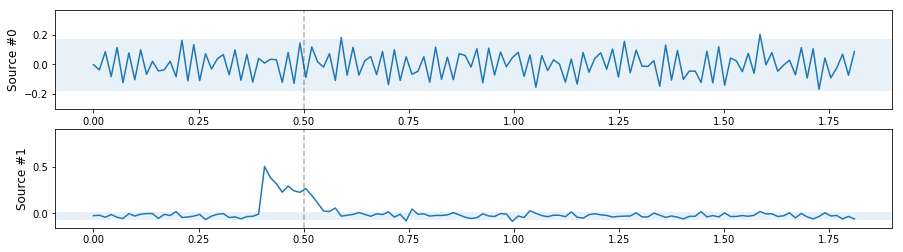

Enter one or more sources number (separate numbers by "," if number of sources > 1): 1


In [37]:
if testing:
    ROIs_filtered,sources,selected_source_idx = denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method='ICA',n_comp=2,wavelet='dmey',autoselect=autoselect)

In [38]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)

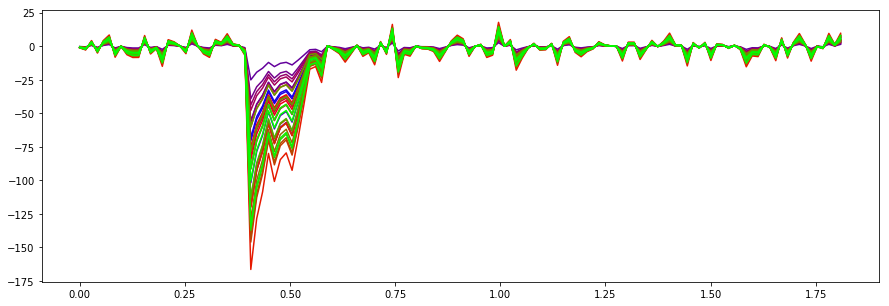

In [40]:
if testing:

    fig, ax1 = plt.subplots(figsize=[15,5])

    for i in range(nregions):

        ax1.plot(time,ROIs_filtered[:,i],color=newcolors[i+1])